# DDQN to Beat Mario

## Background

In 2013, DeepMind made the Deep Q Network to play Atari Games (https://arxiv.org/pdf/1312.5602.pdf). This DQN was able to learn to play simple Atari games at human level, kickstarting the past decade of DeepRL research.

In 2015, DeepMind published another paper which played even more Atari Games (https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf). This new model included a target network to reduce Q-value overestimation in the previous DQN model. This model is sometimes called DDQNs, and it's what we'll implement here to beat Mario!

## Setup and Some Exploration

First, we install gymnasium and the Mario Env.

The Mario env can be found here: https://pypi.org/project/gym-super-mario-bros/

In [ ]:
# uncomment if using colab; if running locally it's recommended to install via conda
!pip install gymnasium
!pip install gym_super_mario_bros==7.3.0

Before we transform the env with wrappers and make our agent, let's take a look at the environment as-is. Below we take some random actions and generate a video

In [ ]:
import gymnasium as gym
from gym.wrappers import RecordVideo

from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

import numpy as np

import warnings
warnings.filterwarnings('ignore')

env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

def run_test(env, num_steps=100):
    frames = []
    out = env.reset()
    for _ in range(num_steps):
        next_state, reward, done, info = env.step(action=env.action_space.sample())
        frames.append(np.copy(env.render(mode='rgb_array')))
    return frames

frames = run_test(env)

In [ ]:
print(frames[-1].shape)

We can reuse the following code to see what our bot does later on:

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os
import cv2

def display_vid(frames, vid_name='./video.mp4', compressed_name='./compressed.mp4', fps=30):
    h, w, c = frames[-1].shape
    out = cv2.VideoWriter(vid_name, cv2.VideoWriter_fourcc(*'DIVX'), fps, (w, h))
    for frame in frames:
        out.write(frame)
    out.release()

    os.system(f"ffmpeg -i {vid_name} -vcodec libx264 {compressed_name}")

    mp4 = open(compressed_name,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

In [ ]:
display_vid(frames)

## Preprocessing Environment

The DeepMind papers for Atari games transforms the environments to make it easier for the DQN/DDQN to learn.

We will implemnet some of these simplifying transformations using Gymnasium's wrappers.

To begin with, we create a wrapper to only use every kth frame. The original paper only uses every fourth frame, with the in-between frames copying the previous action.

Since this requires altering out step function, we will use `gym.Wrapper` as the parent class.

In [ ]:
class SkipFrames(gym.Wrapper):
    def __init__(self, env, skip=4):
        super(SkipFrames, self).__init__(env)
        self.skip = skip

    def step(self, action):

        # accumulate rewards
        total_reward = 0

        for i in range(self.skip):

            # use same action accross all skipped frames
            obs, reward, done, info = self.env.step(action)
            total_reward += reward

            # note that our episode might end during the skipped frames
            # in this case, break the loop
            if done: break
        
        return obs, total_reward, done, info

Next, we will warp each frame (our observation). The original paper
1. converts the screen to grayscale
2. downscales each frame from 210x160 to 110x84
3. crops an 84x84 view of the playing space

In our case, **we will directly downscale to 84x84** since our input frames are already near-square, at (240, 256, 3).

Luckily, the `torchvision.transforms` library can do most of our heavy-lifting. Since we are only altering the observation here, we can use `gym.ObservationWrapper`.

In [ ]:
import torch
from torchvision import transforms as T

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, shape=84):
        super(WarpFrame, self).__init__(env)

        self.width = shape
        self.height = shape

        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shape, shape), dtype=np.uint8)

    #--------------------------------------------------------------------
    # NOTE: gymnasium ObservationWrapper implements reset and step
    #       differently than our env; in particular, it expects
    #       2 items from reset() and 5 items from step(), while
    #       our env gives 1 item from reset() and 4 items from step()
    #--------------------------------------------------------------------
    def reset(self, *, seed = None, options = None):
        obs = self.env.reset(seed=seed, options=options)
        return self.observation(obs)
    def step(self, action):
        observation, reward, terminated, info = self.env.step(action)
        return self.observation(observation), reward, terminated, info
    #--------------------------------------------------------------------
      
    def observation(self, frame):
        assert frame.shape == (240, 256, 3), "Incorrect frame size"

        # set to C, H, W and convert to tensor for transforms
        frame = np.transpose(frame, (2, 0, 1))
        frame = torch.tensor(frame.copy(), dtype=torch.float)

        transforms = T.Compose([
            # converts tensor to grayscale (sets C to 1)
            T.Grayscale(),
            # resizes image using bilinear interpolation
            T.Resize((84, 84)),
            # normalizer takes mean 0 and std 255, thus normalizing vals to [0,1]
            # this is mainly to provide less extreme input to our network (nicer for training)
            T.Normalize(0, 255)
        ])

        return transforms(frame).squeeze()

Finally, the paper takes data from the past 4 observed frames and sends them as a stack to the agent. In the case of Mario, one single state could correspond to mulitple previous actions (e.g. Mario midair could mean he's falling or jumping). So, returning a stack of 4 frames lets the agent glean some context for each state inputs.

Gymnasium already has a `FrameStack` wrapper which we can simply call.

We will also use a Wrapper suggested by the Mario Gym env called `JoypadSpace`. The original NES technically had 256 different viable actions. Here, we will constraing this to `RIGHT_ONLY`, provided by the Mario env, which only allows Mario to move right while jumping/ducking.

In [ ]:
from gym.wrappers import FrameStack
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import RIGHT_ONLY

def preprocessed_env():
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
    env = SkipFrames(env, skip=4)
    env = WarpFrame(env, shape=84)
    env = FrameStack(env, num_stack=4)
    env = JoypadSpace(env, RIGHT_ONLY)
    return env

In [ ]:
env = preprocessed_env()
print('obs space', env.observation_space.shape)
print('act space', env.action_space.n)

We now have a preprocessed environment! We can proceed to working on our Agent.

## Building DDQN

The original DQN paper from 2013 uses the following algorithm:

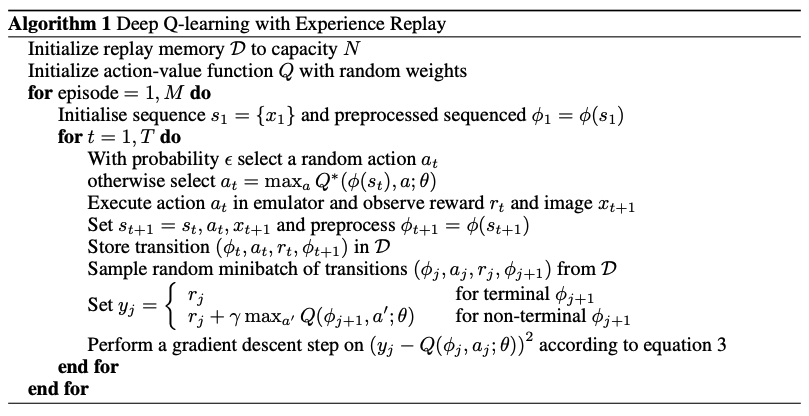

The 2015 paper updates the loss function to that pictured below to include a target network whose parameters, $\theta ^{-}_{i}$, are updated to the Q-network's parameters, $\theta_{i}$ every $C$ steps:

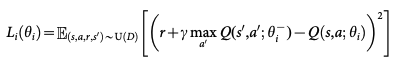

We will first build the solver architecture, then we will proceed to building the agent which implements the above algorithm.

The Q-Network and Target network in our DDQN share the following architecture:
1. Conv2d with 32 8x8 kernels, stride 4 + nonlinearlity (we will use ReLU)
2. Conv2d with 64 4x4 kernels, stride 2 + nonlinearity
3. Conv2d with 64 3x3 kernels, stride 1 + nonlinearity
3. FC layer with 512 nodes + nonlinearity
4. FC layer with # nodes equal to # actions (note this assumes a discrete action space)

We implement this with Pytorch:

In [ ]:
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, obs_space_shape, n_actions, target=False):
        super(DQN, self).__init__()

        self.obs_space_shape = obs_space_shape
        self.n_actions = n_actions

        # convolution steps as described above
        self.conv = nn.Sequential(
            nn.Conv2d(obs_space_shape[0], 32, 8, 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU(),
        )

        # fully connected layers to discrete action space
        conv_out_size = self._get_conv_out_shape()
        self.fcs = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
        )

        if target:
            for p in self.parameters():
                p.requires_grad = False
    
    # helper func to calc conv output size
    def _get_conv_out_shape(self):
        o = self.conv(torch.zeros(1, *self.obs_space_shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv = self.conv(x)
        conv = conv.view(x.size(0), -1)
        out = self.fcs(conv)
        return out

We can test input/output shapes as well

In [ ]:
# tensor of form N, C, H, W
x = torch.tensor(np.random.randint(low=0, high=255, size=(1, 4, 84, 84)), dtype=torch.float)
x = T.Normalize(0, 255)(x)

print('input shape', x.shape)
dqn = DQN(env.observation_space.shape, env.action_space.n)
print('output shape', dqn.forward(x).shape)

As one last step before building our model, we will build a memory system:

In [ ]:
from collections import deque
import random

class AgentMemory():
    def __init__(self, batch_size=32, mem_max=100000):

        # get device
        self.device = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda')
        self.cpu = torch.device('cpu')

        # memory management vars
        self.batch_size = batch_size
        self.mem_max = mem_max
        self.memory = deque(maxlen=self.mem_max)

    def get_batch(self):

        # randomly sample batch of memories
        batch = random.sample(self.memory, self.batch_size)

        # get tensors for each item
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))

        state = state.to(self.device)
        next_state = next_state.to(self.device)
        action = action.to(self.device)
        reward = reward.to(self.device)
        done = done.to(self.device)

        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()
    
    def save_memory(self, state, next_state, action, reward, done):
  
        # save everything as tensors and send to device
        state = torch.from_numpy(state).to(self.cpu)
        next_state = torch.from_numpy(next_state).to(self.cpu)
        action = torch.tensor([action]).to(self.cpu)
        reward = torch.tensor([reward]).to(self.cpu)
        done = torch.tensor([done]).to(self.cpu)

        self.memory.append((state, next_state, action, reward, done))

    def clear_memory(self):

        # reset memory
        self.memory = deque(maxlen=self.mem_max)

    # len hook
    def __len__(self):
        return len(self.memory)

We're finally ready to build our model! We will combine the memory, DNN, and the learning algorithm to create an agent which can improve its optimal Q-value approximations over time.

We'll also throw in some model saving and loading in case our training is interrupted.

In [ ]:
from pathlib import Path

class DDQNAgent:
    def __init__(
        self, obs_space_shape, act_space_shape,
        discount=0.9, lr=2.5e-4,
        sync_every=1e4, learn_every=3, burnin=1e5, save_every=5e5,
        exploration_min=0.02, exploration_max=1, exploration_decay=0.99,
        mem_max=30000, batch_size=32,
        checkpoint_dir='./checkpoints', load_pretrain=False,
    ):
        # get device
        self.device = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda')

        # obs and act space
        self.obs_space_shape = obs_space_shape
        self.act_space_shape = act_space_shape

        # hyperparams
        self.discount = discount
        self.lr = lr
        # exploration_vars
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay
        # loss func
        self.l1 = nn.SmoothL1Loss().to(self.device)

        # exp replay vars
        self.mem_max = mem_max
        self.batch_size = batch_size
        self.mem = AgentMemory(batch_size, mem_max=mem_max)
        self.curr_step = 0
        self.sync_every = sync_every
        self.learn_every = learn_every
        self.burnin = burnin
        self.save_every = save_every
        

        # save loc
        self.checkpoint_dir = checkpoint_dir

        # load pretrained or proceed with init
        if load_pretrain:
            # load dqn weights and optimizer state
            self.load_model(load_fn='model_opt.pth')
        # make new networks
        else:
            # make q network and target network
            self.q_net = DQN(self.obs_space_shape, self.act_space_shape)
            self.target = DQN(self.obs_space_shape, self.act_space_shape, target=True)
            # finally set optimizer for our dqn net
            self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        
        self.q_net.to(self.device)
        self.target.to(self.device)

    def act(self, state):

        self.curr_step += 1

        action = -1
        state = torch.from_numpy(state.__array__()).to(self.device)

        if np.random.rand() < self.exploration_rate:
            action = np.random.randint(self.act_space_shape)
        else:
            state = state.to(self.device).unsqueeze(0)
            out = self.q_net(state)
            action = torch.argmax(out, axis=1).item()

        return action

    def copy_model(self):        
        self.target.load_state_dict(self.q_net.state_dict())

    def learn(self):

        if self.curr_step % self.sync_every == 0:
            self.copy_model()
        if self.curr_step % self.save_every == 0:
            self.save_model()
        if self.curr_step < self.burnin:
            return
        if self.curr_step % self.learn_every != 0:
            return
        # if self.batch_size > len(self.mem):
        #     return
        
        # get batched memories
        state, next_state, action, reward, done = self.mem.get_batch()

        # zero out gradients
        self.optimizer.zero_grad()

        # recall loss func computes r + γ max_a' Q(s', a'; 𝜃-) - Q(s, a; 𝜃)

        # # γ max_a' Q(s', a'; 𝜃-)
        targ_update = self.discount * self.target(next_state).max(1).values.unsqueeze(1)
        targ_update = targ_update * (~done).long()

        # # r + γ max_a' Q(s', a'; 𝜃-)
        target = reward + targ_update

        # # Q(s, a; 𝜃)
        current = self.q_net(state).max(1).values.unsqueeze(1)

        # # loss here is | r + γ max_a' Q(s', a'; 𝜃-) - Q(s, a; 𝜃) |
        loss = self.l1(current, target)

        
        # backprop and descent
        loss.backward()
        self.optimizer.step()
        
        # update exploration rate
        self.exploration_rate *= self.exploration_decay
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)
        
    
    # conveniece methods to interact with child objects
    def save_memory(self, *args):
        self.mem.save_memory(*args)
    def train(self):
        self.q_net.train()
    def eval(self):
        self.q_net.eval()
    

    # model save/load functions
    def load_model(self, load_fn='model_opt.pth', num=0):
        self.q_net = DQN(self.obs_space_shape, self.act_space_shape)
        self.target = DQN(self.obs_space_shape, self.act_space_shape, target=True)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=self.lr)

        load_path = Path(self.checkpoint_dir) / Path(load_fn)
        checkpoint = torch.load(load_path, map_location='cpu')

        self.q_net.model.load_state_dict(checkpoint['qnet_state_dict'])
        self.target.model.load_state_dict(checkpoint['target_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.exploration_rate = checkpoint['explore_rate']

    def save_model(self, save_fn='model_opt.pth'):

        save_path = Path(self.checkpoint_dir) / Path(save_fn)

        torch.save({
            'qnet_state_dict': self.q_net.state_dict(),
            'target_state_dict': self.target.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'explore_rate': self.exploration_rate,
        }, save_path)

## Training

We will log to WandB to see how training progresses

In [ ]:
# Uncomment if using colab
!pip install wandb

In [ ]:
import wandb

wandb.login()

In [ ]:
NUM_EPISODES = 10000
BATCH_SIZE = 32
LR = 0.00025
DISCOUNT = 0.9
EXPLORATION_DECAY = 0.99999975
EXPLORATION_MIN = 0.1
EXPLORATION_MAX = 1
MEM_MAX = 100000
SYNC_EVERY = 1e4
LEARN_EVERY = 3
BURNIN = 1e5
SAVE_EVERY = 5e5

In [ ]:
from tqdm import tqdm

def train_agent(
    num_episodes=NUM_EPISODES, discount=DISCOUNT, lr=LR,
    exploration_min=EXPLORATION_MIN, exploration_max=EXPLORATION_MAX, exploration_decay=EXPLORATION_DECAY,
    mem_max=MEM_MAX, batch_size=BATCH_SIZE,
    sync_every=SYNC_EVERY, learn_every=LEARN_EVERY, burnin=BURNIN, save_every=SAVE_EVERY,
    checkpoint_dir='./checkpoints', load_pretrain=False,
    log_ep_reward_trend_every = 1000, wandb_logging=True
):
    device = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda')

    env = preprocessed_env()
    obs_space_shape = env.observation_space.shape
    act_space_shape = env.action_space.n

    agent = DDQNAgent(
        obs_space_shape=obs_space_shape,
        act_space_shape=act_space_shape,
        discount=discount, lr=lr,
        exploration_min=exploration_min, exploration_max=exploration_max, exploration_decay=exploration_decay,
        mem_max=mem_max, batch_size=batch_size,
        checkpoint_dir=checkpoint_dir, load_pretrain=load_pretrain,
    )

    # stat logging
    total_rewards = []
    ep_lens = []
    tot_rewards_by_ep = dict()

    # prep env and agent for training
    env.reset()
    agent.train()

    for episode in tqdm(range(num_episodes)):
        total_reward = 0
        step = 0
        ep_rewards = []

        log_reward_trend = (episode % log_ep_reward_trend_every == 0) or (episode == num_episodes - 1)

        state = env.reset()
        state = state.__array__()

        while True:
            step += 1

            # get action from agent
            action = agent.act(state)
            
            # step using action
            next_state, reward, done, info = env.step(action=action)

            # accumulate reward for episode and save
            total_reward += reward

            # add experience to memory
            next_state = next_state.__array__()
            agent.save_memory(state, next_state, action, reward, done)

            # perform experience replay
            agent.learn()

            # prep for next loop
            state = next_state

            # break loop if end of episode
            if done: break

            if log_reward_trend:
                ep_rewards.append(total_reward)

        # save/log episode metrics
        total_rewards.append(total_reward)
        ep_lens.append(step)
        if log_reward_trend:
            tot_rewards_by_ep[episode] = ep_rewards
            agent.save_model(save_fn=f'model_opt_{episode}.pth')

        if wandb_logging:
            sum_past_n = sum(total_rewards[:-500])
            len_past_n = len(total_rewards[:-500])

            avg_past_n = 0
            if len_past_n != 0:
                avg_past_n = sum_past_n / len_past_n
            wandb.log({
                'train/total_reward': total_reward,
                'train/avg_reward (past 500 episodes)': avg_past_n,
                'train/episode_len': step,
            })
    
    return agent, env, total_rewards, ep_lens, tot_rewards_by_ep

In [ ]:
run = wandb.init(
    project='Mario DQN',
    notes='Training a DQN similar to the original DeepMind paper for Atari Games.'
)

wandb.config = {
    'episodes': NUM_EPISODES,
    'batch_size': BATCH_SIZE,
    'learning_rate': LR,
    'discount': DISCOUNT,
    'exploration_decay': EXPLORATION_DECAY,
    'exploration_min': EXPLORATION_MIN,
    'exploration_max': EXPLORATION_MAX,
    'mem_max': MEM_MAX,
    'sync_every': SYNC_EVERY,
    'learn_every': LEARN_EVERY,
    'burnin': BURNIN,
    'save_every': SAVE_EVERY,
}

!mkdir ./checkpoints

agent, env, total_rewards, ep_lens, tot_rewards_by_ep = train_agent(wandb_logging=True)

In [ ]:
import pickle

with open('tot_rewards_by_ep.pkl', 'wb') as fp:
    pickle.dump(tot_rewards_by_ep, fp)
    print('dictionary saved successfully to file')